In [1]:
import os
os.environ["VRE_LOGLEVEL"] = "0"
from pathlib import Path
from pprint import pprint
import subprocess
from omegaconf import OmegaConf
from vre.representations import build_representations_from_cfg, ReprOut, Representation
from vre.readers.multitask_dataset import MultiTaskDataset, MultiTaskItem
from vre.utils import reorder_dict, collage_fn, image_add_title, get_project_root, MemoryData

import numpy as np
import torch as tr
import matplotlib.pyplot as plt

from semantic_mapper import plot_one

%load_ext autoreload
%autoreload 2
%matplotlib inline

/export/home/proiecte/aux/mihai_cristian.pirvu/.conda/envs/ngc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define the data path.
It can be a normal video (mp4) or a previous export of VRE if it contains the 6 relevant 'seed' experts:
- rgb
- opticalflow_rife
- depth_marigold
- normals_svd(depth_marigold)
- semantic_mask2former_mapillary_49189528_0
- semantic_mask2former_coco_47429163_0

You can also generate it using `vre /path/to/video.mp4 -o out_dir --config_path cfg.yaml`

In [2]:
cfg_path = Path.cwd() / "cfg.yaml"
# data_path = get_project_root() / "resources/test_video.mp4" # It can also be a previously exported VRE dir
data_path = Path.cwd() / "data"
vre_dir = data_path
if data_path.suffix == ".mp4":
    vre_dir = Path.cwd() / f"data_{data_path.name}"
    frames = ["1", "100", "1000", "3000"]
    if not vre_dir.exists():
        subprocess.run(args=["vre", str(data_path), "--config_path", str(cfg_path),
                             "-o", str(vre_dir), "--frames", *frames],
                        env={**os.environ.copy(), **{"VRE_DEVICE": "cuda" if tr.cuda.is_available() else "cpu"}})
    else:
        print(f"Out dir '{vre_dir}' exists. Remove it first")
else:
    print("Not a video, but a dir of exported VRE results. Skipping")

Not a video, but a dir of exported VRE results. Skipping


#### Instantiate the MultiTaskDataset object

This is only done for the initial seed expert tasks defined earlier. We'll also plot them.

[2024-11-24T15:04:16 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:81)


[2024-11-24T15:04:17 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:81)
[2024-11-24T15:04:17 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:81)
[2024-11-24T15:04:17 VRE-INFO] Building 'optical-flow/rife' (vre name: opticalflow_rife) (build_representations.py:build_representation_from_cfg:81)
[2024-11-24T15:04:17 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:81)
[2024-11-24T15:04:17 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:81)
[2024-11-24T15:04:17 VRE-INFO] Tasks used in this dataset: ['depth_marigold', 'normals_svd(depth_marigold)', 'opticalflow_rife', 'rgb', 'semantic_mask2former_coco_47429163_0', 'semantic_

[MultiTaskDataset]
 - Path: '/export/home/proiecte/aux/mihai_cristian.pirvu/code/semantic-mapper/data'
 - Tasks (6): [Marigold(depth_marigold ['depth_marigold']), DepthNormalsSVD(normals_svd(depth_marigold) ['normals_svd(depth_marigold)']), FlowRife(opticalflow_rife ['opticalflow_rife']), RGB(rgb ['rgb']), Mask2Former(semantic_mask2former_coco_47429163_0 ['semantic_mask2former_coco_47429163_0']), Mask2Former(semantic_mask2former_mapillary_49189528_0 ['semantic_mask2former_mapillary_49189528_0'])]
 - Classification tasks (2): [Mask2Former(semantic_mask2former_coco_47429163_0 ['semantic_mask2former_coco_47429163_0']), Mask2Former(semantic_mask2former_mapillary_49189528_0 ['semantic_mask2former_mapillary_49189528_0'])]
 - Length: 31
 - Handle missing data mode: 'fill_nan'
 - Normalization: '{'depth_marigold': 'min_max', 'normals_svd(depth_marigold)': 'min_max', 'opticalflow_rife': 'min_max', 'rgb': 'min_max', 'semantic_mask2former_coco_47429163_0': None, 'semantic_mask2former_mapillary_49

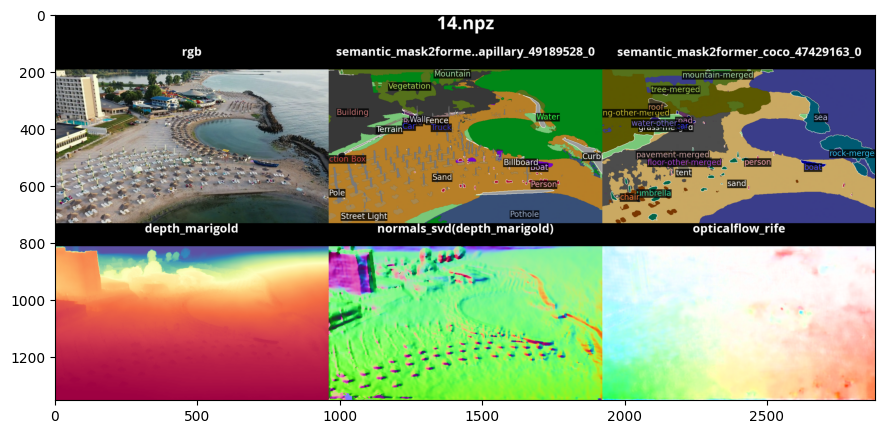

In [3]:
task_names = ["rgb", "depth_marigold", "normals_svd(depth_marigold)", "opticalflow_rife",
              "semantic_mask2former_coco_47429163_0", "semantic_mask2former_mapillary_49189528_0"]
order = ["rgb", "semantic_mask2former_mapillary_49189528_0", "semantic_mask2former_coco_47429163_0",
            "depth_marigold", "normals_svd(depth_marigold)"]

representations = build_representations_from_cfg(OmegaConf.load(cfg_path))
reader = MultiTaskDataset(vre_dir, task_names=task_names,
                          task_types=representations, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)
orig_task_names = list(reader.task_types.keys())

print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

data, name = reader[np.random.randint(0, len(reader))]
collage = plot_one(data, title=name, order=order, name_to_task=reader.name_to_task)
plt.figure(figsize=(15, 5))
plt.imshow(collage)
plt.show()

#### Add the newly defined tasks

Thery are read from `semantic_mapper.py` but you can define new ones here too using the primitives from there.
Each of them is added to the MultiTaskDataset object one by one.

The computation in the reader is done on the fly, meaning they are derived from the underlying existing experts
on the fly.

[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'semantic_mask2former_swin_mapillary_converted' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'semantic_mask2former_swin_coco_converted' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'buildings' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'living-vs-non-living' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'sky-and-water' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'transportation' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'containing' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'vegetation' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 VRE-INFO] Adding a new task: 'buildings(nearby)' (multitask_dataset.py:add_task:206)
[2024-11-24T15:04:20 

== Random loaded item ==
{'buildings': tr[540, 960] f32 x∈[1.0, 1.0], 'buildings(nearby)': tr[540, 960] f32 x∈[1.0, 1.0], 'containing': tr[540, 960] f32 x∈[0.0, 1.0], 'depth_marigold': tr[540, 960] f32 x∈[0.0, 1.0], 'living-vs-non-living': tr[540, 960] f32 x∈[1.0, 1.0], 'normals_svd(depth_marigold)': tr[540, 960, 3] f32 x∈[0.0, 1.0], 'opticalflow_rife': tr[540, 960, 2] f32 x∈[0.4, 0.55], 'rgb': tr[540, 960, 3] f32 x∈[0.0, 1.0], 'safe-landing-no-sseg': tr[540, 960] f32 x∈[0.0, 1.0], 'safe-landing-semantics': tr[540, 960] f32 x∈[0.0, 1.0], 'semantic_mask2former_coco_47429163_0': tr[540, 960] u8 x∈[19, 126], 'semantic_mask2former_mapillary_49189528_0': tr[540, 960] u8 x∈[3, 45], 'semantic_mask2former_swin_coco_converted': tr[540, 960, 8] f64 x∈[0.0, 1.0], 'semantic_mask2former_swin_mapillary_converted': tr[540, 960, 8] f64 x∈[0.0, 1.0], 'sky-and-water': tr[540, 960] f32 x∈[0.0, 1.0], 'transportation': tr[540, 960] f32 x∈[1.0, 1.0], 'vegetation': tr[540, 960] f32 x∈[0.0, 1.0]}


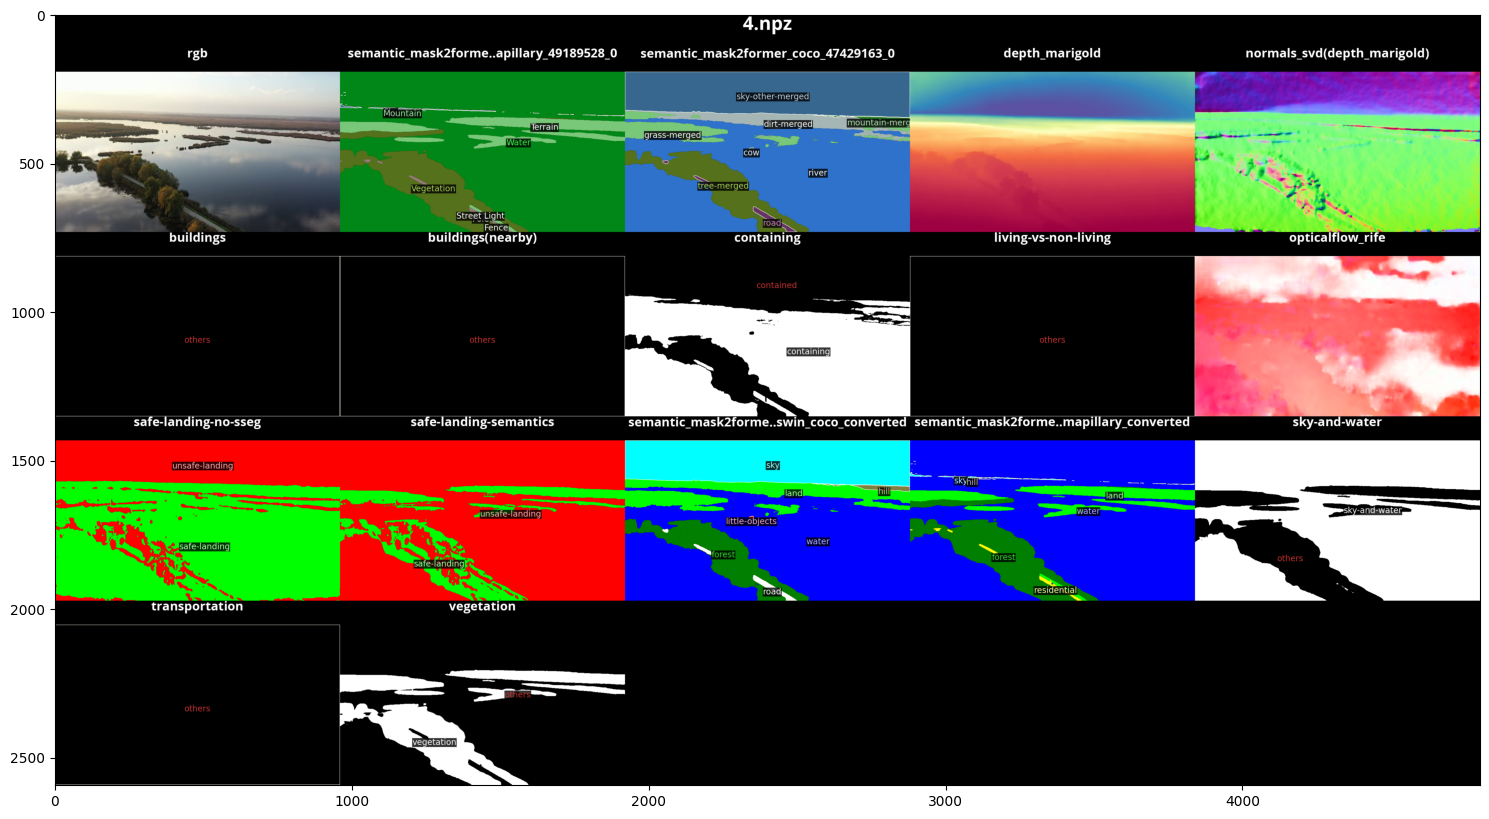

In [4]:
from semantic_mapper import get_new_semantic_mapped_tasks # put this here for auto loading
new_tasks = get_new_semantic_mapped_tasks()
for task_name in reader.task_names:
    if task_name not in orig_task_names:
        reader.remove_task(task_name)
for new_task in new_tasks.values():
    reader.add_task(new_task, overwrite=True)

print("== Random loaded item ==")
ixs = np.random.permutation(range(len(reader))).tolist()
for ix in ixs:
    data, name = reader[ix]
    print(data)
    plt.figure(figsize=(20, 10))
    plt.imshow(collage := plot_one(data, title=name, order=order, name_to_task=reader.name_to_task))
    plt.show()
    break